# Analysis of BRCA1 saturation mutagenesis data

In the following we compare predictions from Rhapsody, PolyPhen-2 and EVmutation against experimental functional assessments of BRCA1 mutants presented in:
[Findlay GM et al, *Accurate classification of BRCA1 variants with saturation genome editing*, Nature (2018)](https://www.nature.com/articles/s41586-018-0461-z)

In [1]:
import sys, os, pickle, csv, glob
import numpy as np

In [2]:
# If needed, insert here local path to Rhapsody folder with the command:
# sys.path.insert(0, '/LOCAL_PATH/rhapsody/')
import rhapsody as rhaps

## Integrated Dataset
Let's import the training dataset. We will only consider variants in the Integrated Dataset with at least 1 ClinVar review star, if present, and an associated PDB structure larger than 150 residues, two restrictions that we found to improve prediction accuracy.

In [3]:
ID = np.load('../00-Training_Dataset/local/data/precomputed_features-ID_opt.npy')
len(ID)

20361

## Re-training of unbiased classifier

A few BRCA1 mutations are found in the Integrated Dataset used for training. In order to get completely unbiased predictions, we will retrain a classifier by excluding those variants from the training dataset.

**NB:** The Uniprot ID for gene BRCA1 is `P38398`.

In [4]:
known_EGFR_SAVs = ID[ [SAV.startswith('P38398') for SAV in ID['SAV_coords']] ]

known_del_SAVs = known_EGFR_SAVs[ known_EGFR_SAVs['true_label'] == 1 ]
known_neu_SAVs = known_EGFR_SAVs[ known_EGFR_SAVs['true_label'] == 0 ]

print(f'{len(known_del_SAVs)} known deleterious BRCA1 SAVs in ID')
# print(known_del_SAVs)
print(f'{len(known_neu_SAVs)} known neutral BRCA1 SAVs in ID')
# print(known_neu_SAVs)

29 known deleterious BRCA1 SAVs in ID
10 known neutral BRCA1 SAVs in ID


Let's exclude these variants from the dataset. 

In [5]:
ID_subset = ID[ [not SAV.startswith('P38398') for SAV in ID['SAV_coords']] ]
len(ID_subset)

20322

We use this subset of the Integrated Dataset to train unbiased versions of Rhapsody classifiers:

In [6]:
featsets = {
    'full_clsf': [ 'wt_PSIC', 'Delta_PSIC', 'SASA', 
                   'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                   'stiffness-chain', 'entropy', 'ranked_MI', 'BLOSUM' ],
    'redx_clsf': [ 'wt_PSIC', 'Delta_PSIC', 'SASA', 
                   'ANM_MSF-chain', 'ANM_effectiveness-chain', 'ANM_sensitivity-chain',
                   'stiffness-chain', 'BLOSUM' ]
}

In [7]:
if not os.path.isdir('local'):
    os.mkdir('local')

In [8]:
from prody import LOGGER

if os.path.isdir('local/results'):
    print('Classifiers already trained.')
else:
    os.mkdir('local/results/')
    
    LOGGER.start('local/results/RF_training.log')
    summaries = {}
    
    for clsf_version, featset in featsets.items():
        folder = f'local/results/{clsf_version}'
        os.mkdir(folder)
        
        f = ['SAV_coords', 'true_label'] + featset
        output_dict = rhaps.trainRFclassifier(ID_subset[f])
        summaries[clsf_version] = output_dict['CV summary']
        
        for file in glob.glob('*png') + ['trained_classifier.pkl',]:
            os.rename(file, os.path.join(folder, file))
            
        LOGGER.info('')
                    
    # store training summary into pickle
    pickle.dump(summaries, open('local/results/summaries.pkl', 'wb'))

    LOGGER.close('local/results/RF_training.log')

Classifiers already trained.


## Rhapsody predictions
We perform a complete scanning of all amino acid variants (*in silico* saturation mutagenesis).

**NB:** PolyPhen-2 predictions are precomputed and saved in `data/pph2`

In [9]:
if os.path.isdir('local/results/predictions'):
    print('predictions already precomputed')
    rh = pickle.load(open('local/results/predictions/rhapsody-pickle.pkl', 'rb'))
else:
    os.mkdir('local/results/predictions')
    # run rhapsody
    rh = rhaps.rhapsody('data/pph2/pph2-full.txt', 'local/results/full_clsf/trained_classifier.pkl',
                        aux_classifier='local/results/redx_clsf/trained_classifier.pkl', input_type='PP2')
    # store files
    for f in glob.glob('rhapsody-*.*'):
        os.rename(f, os.path.join('local/results/predictions', f))

predictions already precomputed


## Comparison with experimental data from Findlay et al.
Let's import data from a `csv` file adapted from the paper's Supplementary Material:

In [10]:
import csv

imported_data = {}
with open('data/data_from_paper.csv', 'r') as csvfile:
    table = csv.reader(csvfile, delimiter=',')
    for i, line in enumerate(table):
        if i < 3:
            # skip headers
            continue
        elif line[14] == 'Missense':
            SAV = f'P38398 {line[10]} {line[11]} {line[12]}'
            exp_score  = float(line[15])
            exp_class = line[16]
            # store data in dictionary
            imported_data.setdefault(SAV, [])
            imported_data[SAV].append( (exp_score, exp_class) )
            
# example:
imported_data['P38398 1 M L']

[(-2.5165293733, 'LOF'), (-1.9656286042, 'LOF')]

Variants are categorized in three classes (*functional, intermediate, loss-of-function*) based on their functional effects:

In [11]:
set( [t[1] for l in imported_data.values() for t in l ] )

{'FUNC', 'INT', 'LOF'}

Since different SNPs may map to the same SAV, we'll take the average of functional scores:

In [12]:
dt = np.dtype([('SAV coords', '<U25'), ('funct. score', '<f4'), ('funct. classes', '<U25')])
exp_data = np.empty(len(rh.SAVcoords), dtype=dt)

for i, SAV in enumerate(rh.SAVcoords['text']):
    avg_score = np.nan
    funct_classes = '?'
    if SAV in imported_data:
        avg_score = np.nanmean(  [t[0] for t in imported_data[SAV]])
        funct_classes = ','.join([t[1] for t in imported_data[SAV]])
    exp_data[i] = (SAV, avg_score, funct_classes)
    
# example:
exp_data[9]

('P38398 1 M L', -2.241079, 'LOF,LOF')

In [13]:
# compute residue-averaged functional effects
avg_exp_score = np.nanmean(exp_data['funct. score'].reshape((-1, 19)), axis=1)

/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


### Spearman correlation

In the following, we compute and plot the correlation between experimental measurements and computational predictions for the functional arrays.

In [14]:
# computational scores
comput_scores = {
    'Rhapsody'   : rh.mixPreds['score'],
    'PolyPhen-2' : np.array([float(x) for x in rh.PP2output['pph2_prob']]),
    'EVmutation' : - np.array([float(x) for x in rh.calcEVmutationFeats()['EVmut-DeltaE_epist']])
}

# compute residue-averaged computational scores
avg_comput_scores = {}
for method, score in comput_scores.items():
    avg_comput_scores[method] = np.nanmean(score.reshape((-1, 19)), axis=1)

@> Recovering EVmutation data...
@> EVmutation scores recovered in 59.7s.
/home/lponzoni/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [15]:
if not os.path.isdir('local/figures'):
    os.mkdir('local/figures')

In [16]:
from scipy.stats.stats import spearmanr
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12,4))

for i, method in enumerate(['Rhapsody', 'PolyPhen-2', 'EVmutation']):
    ax = axes[i]
    # individual scores
    es = exp_data['funct. score']
    cs = comput_scores[method]
    ax.scatter(es, cs, marker='.')
    sel = np.logical_and(~np.isnan(es), ~np.isnan(cs))
    rho = spearmanr(es[sel], cs[sel])[0]
    # residue-averaged scores
    aes = avg_exp_score
    acs = avg_comput_scores[method]
    ax.scatter(aes, acs, marker='.', c='r')
    sel = np.logical_and(~np.isnan(aes), ~np.isnan(acs))
    rho_av = spearmanr(aes[sel], acs[sel])[0]
    # print labels
    ax.set_ylabel(method)
    s = r'$\rho$'
    ax.set_title(f'{s}={rho:5.2f} (avg: {rho_av:5.2f})')
    ax.set_xlabel('exp. functional score')

    fig.tight_layout()
    plt.savefig(f'local/figures/correlations.png', dpi=300);

### ROCs, Precision-Recall curves and other metrics

We will make use of the variant classification provided by the paper, by applying the following three conventions:

In [17]:
schemes = [
    { 'LOF': 'del', 'INT': '?',   'FUNC': 'neu'},
    { 'LOF': 'del', 'INT': 'del', 'FUNC': 'neu'},
    { 'LOF': 'del', 'INT': 'neu', 'FUNC': 'neu'}
]

We will discard variants with discordant classifications.

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

metrics = {}

# loop over computational methods 
for method in ['Rhapsody', 'Rhapsody ∩ EVmut',  'Rhapsody \ EVmut',
               'PolyPhen-2', 'PolyPhen-2 ∩ EVmut',  'PolyPhen-2 \ EVmut',
               'EVmutation']:

    if method.endswith('∩ EVmut'):
        orig_meth = method.split()[0]
        comput_score = comput_scores[orig_meth].copy()
        # keep predictions only if EVmutation does have them as well
        comput_score[np.isnan(comput_scores['EVmutation'])] = np.nan
    elif method.endswith('\ EVmut'):
        orig_meth = method.split()[0]
        comput_score = comput_scores[orig_meth].copy()
        # keep only predictions that don't have EVmutation scores too
        comput_score[~np.isnan(comput_scores['EVmutation'])] = np.nan
    else:
        comput_score = comput_scores[method]

    # loop over classification schemes
    metrics[method] = []
    for i, scheme in enumerate(schemes):
                
        exp_bin_labels = np.zeros(len(exp_data['funct. classes']), dtype=int)
        for i, cls in enumerate(exp_data['funct. classes']):
            if cls == '?':
                exp_bin_labels[i] = -1
            else:
                cl = set( [scheme[s] for s in cls.split(',')] )
                if cl == {'del'}:
                    exp_bin_labels[i] = 1
                elif cl == {'neu'}:
                    exp_bin_labels[i] = 0
                else:
                    exp_bin_labels[i] = -1
        
        # curves and metrics
        m = {}
        
        sel = np.logical_and(exp_bin_labels!=-1, ~np.isnan(comput_score))
        el = exp_bin_labels[sel]
        cs = comput_score[sel]
        
        m['n.SAVs'] = len(el)
        fpr, tpr, _ = roc_curve(el, cs)
        prc, rec, _ = precision_recall_curve(el, cs)
        m['ROC']   = (fpr, tpr)
        m['PRC']   = (prc, rec)
        m['AUROC'] = roc_auc_score(el, cs)
        m['AUPRC'] = average_precision_score(el, cs)

        metrics[method].append(m)

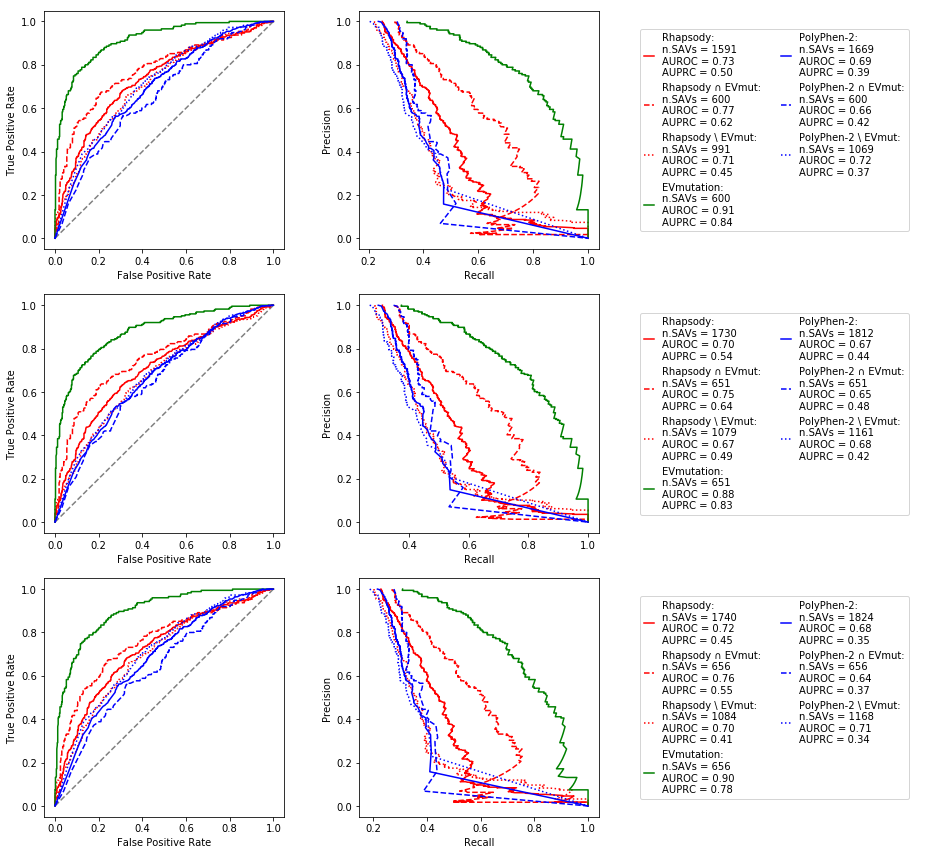

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(13,12))

for i in range(3):

    ax_roc = axes[i,0]
    ax_prc = axes[i,1]
    ax_lgd = axes[i,2]
    
    # random ROC
    ax_roc.plot([0,1], [0,1], '--', color='gray')
    
    for method in ['Rhapsody', 'Rhapsody ∩ EVmut',  'Rhapsody \ EVmut',
                   'EVmutation',
                   'PolyPhen-2', 'PolyPhen-2 ∩ EVmut',  'PolyPhen-2 \ EVmut']:

        if method.startswith('Rhapsody'):
            color = 'r'
        elif method.startswith('PolyPhen-2'):
            color = 'b'
        else:
            color = 'g'
            
        if method.endswith('∩ EVmut'):
            ls = '--'
        elif method.endswith('\ EVmut'):
            ls = ':'
        else:
            ls = '-'
        
        m = metrics[method][i]
        
        line = color + ls 
        
        l  = f"{method}:\n"
        l += f"n.SAVs = {m['n.SAVs']}\n"
        l += f"AUROC = {m['AUROC']:4.2f}\n"
        l += f"AUPRC = {m['AUPRC']:4.2f}"
        ax_roc.plot(m['ROC'][0], m['ROC'][1], line, label=l)
        
        l = f"AUPRC={m['AUPRC']:4.2f}"
        ax_prc.plot(m['PRC'][0], m['PRC'][1], line)    
    
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    
    ax_prc.set_xlabel('Recall')
    ax_prc.set_ylabel('Precision')
    
    ax_lgd.axis('off')
    handles, labels = ax_roc.get_legend_handles_labels()
    ax_lgd.legend(handles, labels, handlelength=1, ncol=2, loc='right')

fig.tight_layout()    
fig.savefig(f'local/figures/ROC-PRC.png', dpi=300)

### *In silico* saturation mutagenesis table

We will only plot the predictions for the two segments of the sequence corresponding to RING and BRCT domains, where PDB structures are available and therefore Rhapsody can compute predictions.

Experimental measurements are reversed, shifted and rescaled on the `[0, 1]` interval to make easier a comparison between residue-averaged profiles on the figure.

In [20]:
exp_score = - exp_data['funct. score']
exp_score = exp_score - np.nanmin(exp_score)
exp_score /= np.nanmax(avg_exp_score) - np.nanmin(avg_exp_score)

In [21]:
rhaps.print_sat_mutagen_figure('local/figures/sat_mutagen-RING', rh, extra_plot=exp_score, 
                               res_interval=(0,105),     fig_width=10.5*1.2)
rhaps.print_sat_mutagen_figure('local/figures/sat_mutagen-BRCT', rh, extra_plot=exp_score, 
                               res_interval=(1645,1865), fig_width=22*1.2)

@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-RING.png
@> Saturation mutagenesis figure saved to local/figures/sat_mutagen-BRCT.png


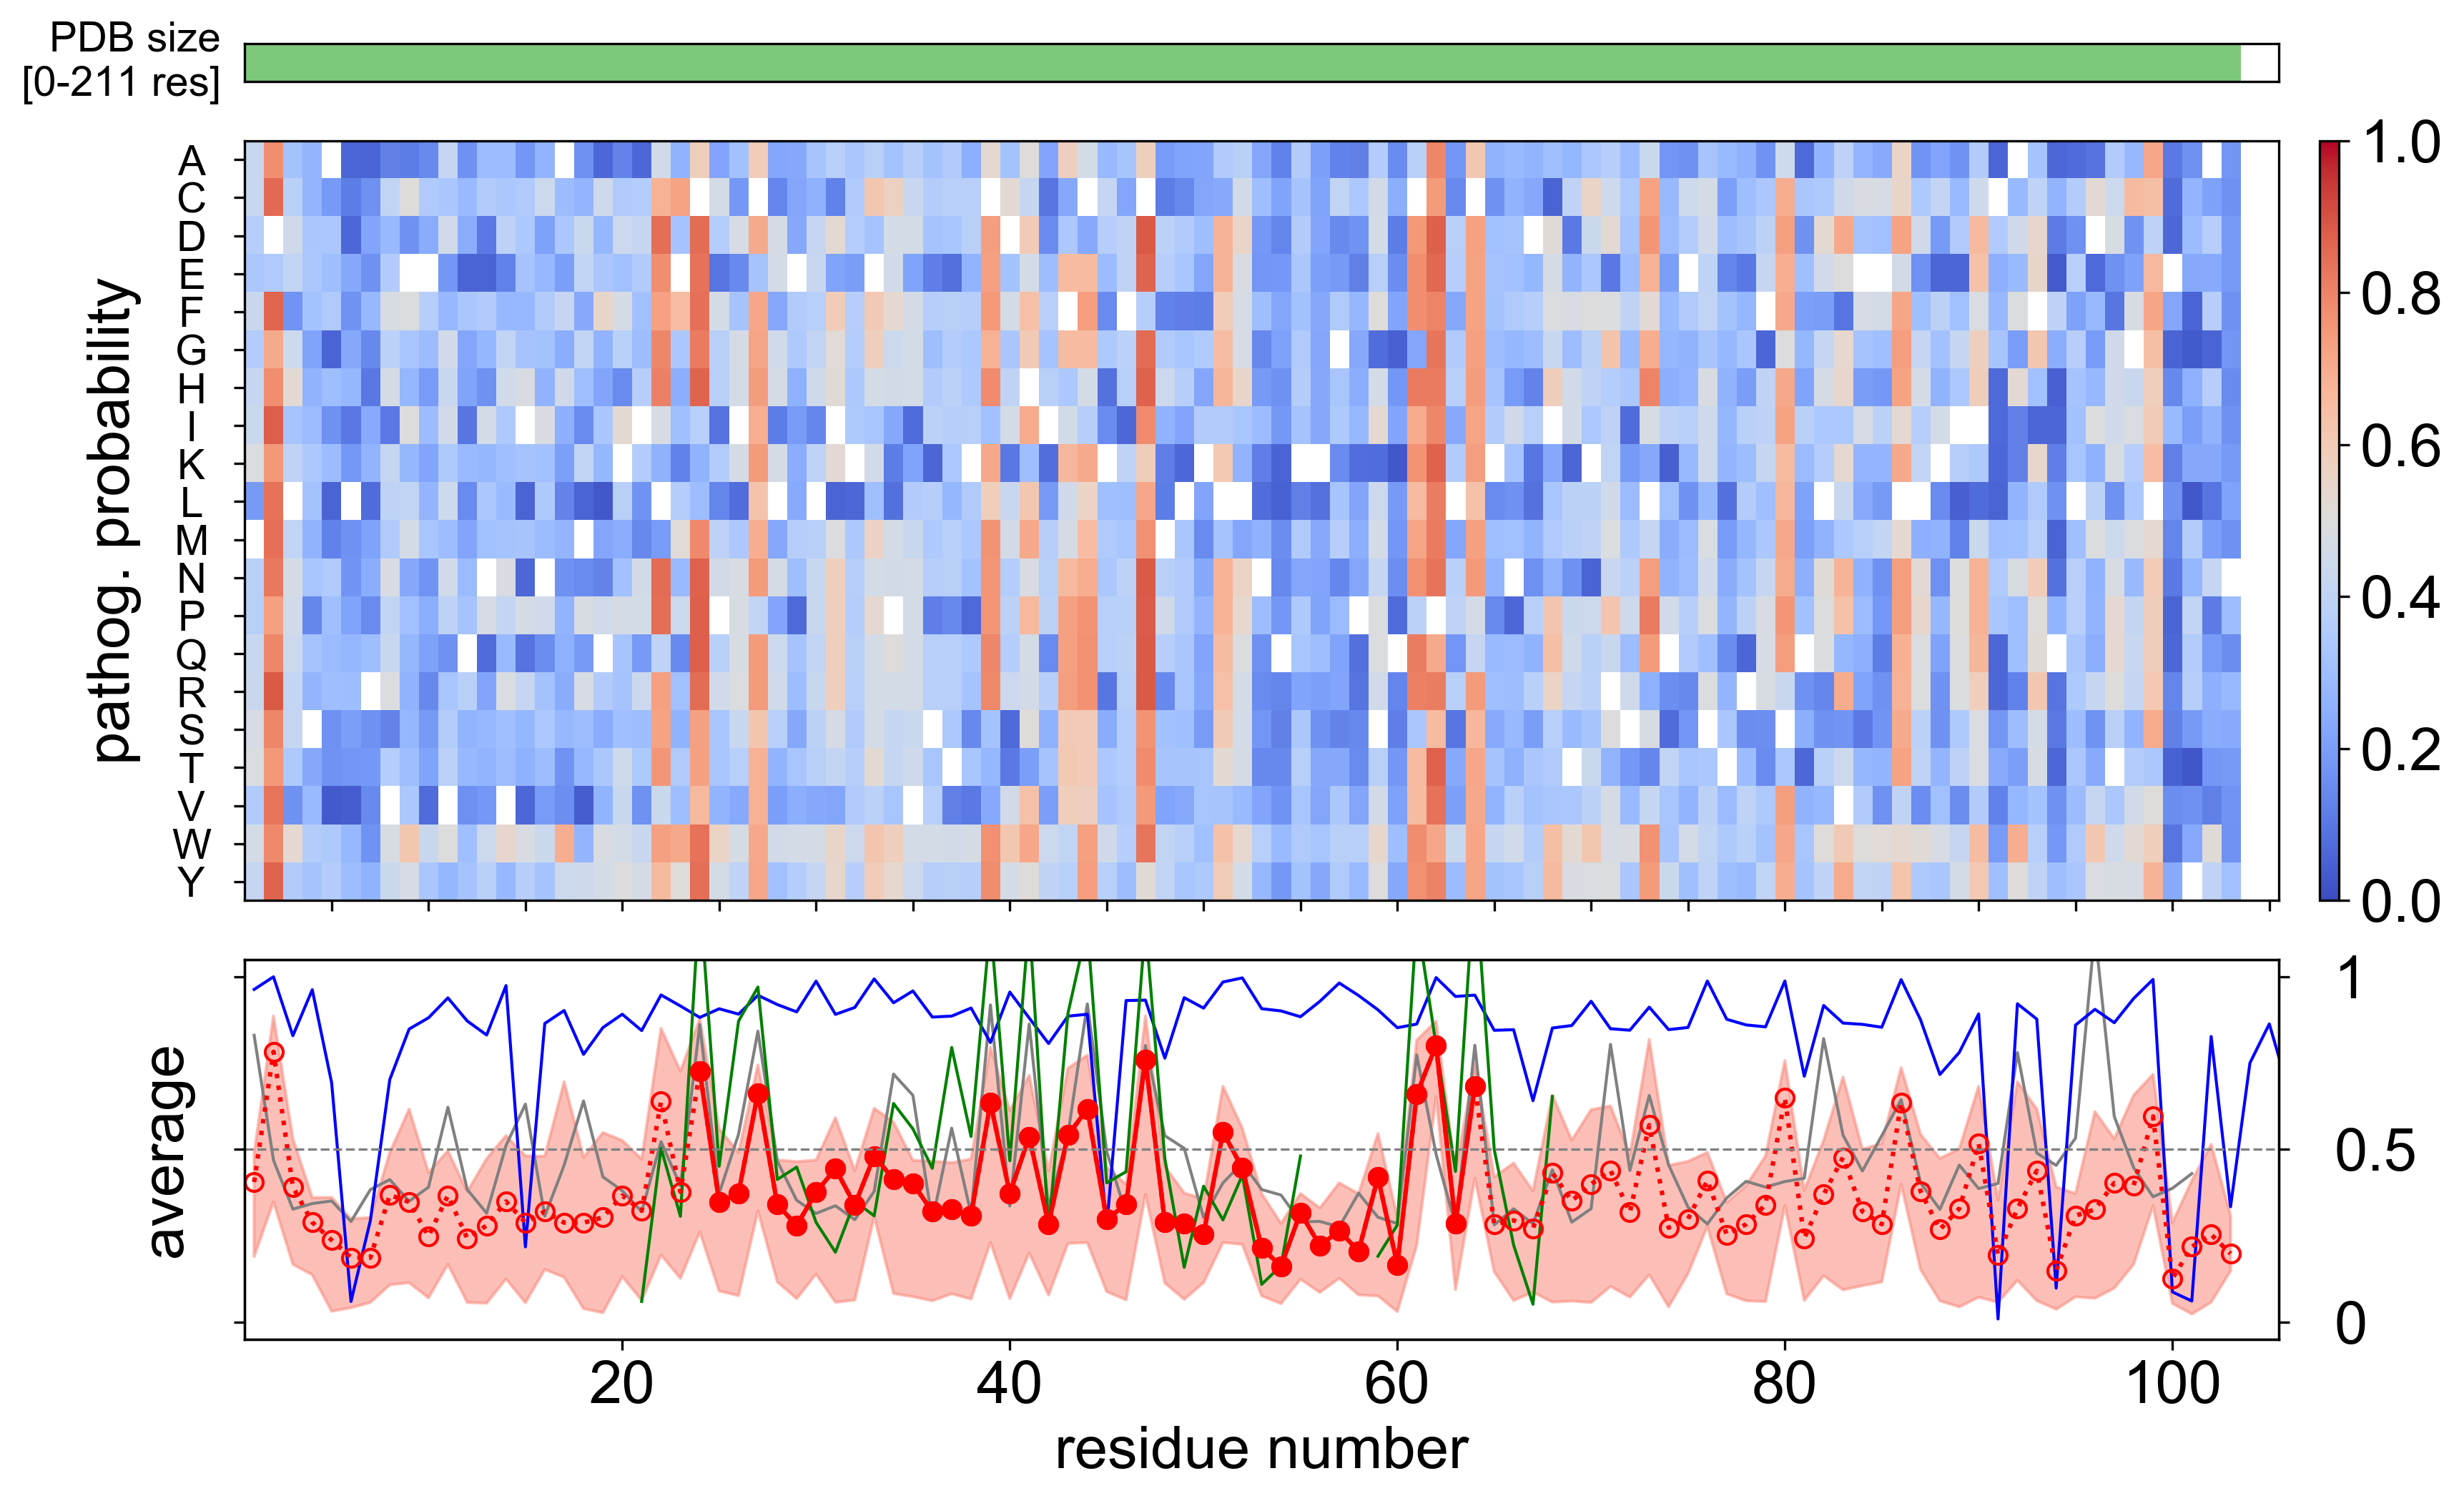

In [22]:
from IPython.display import Image
Image('local/figures/sat_mutagen-RING.png')

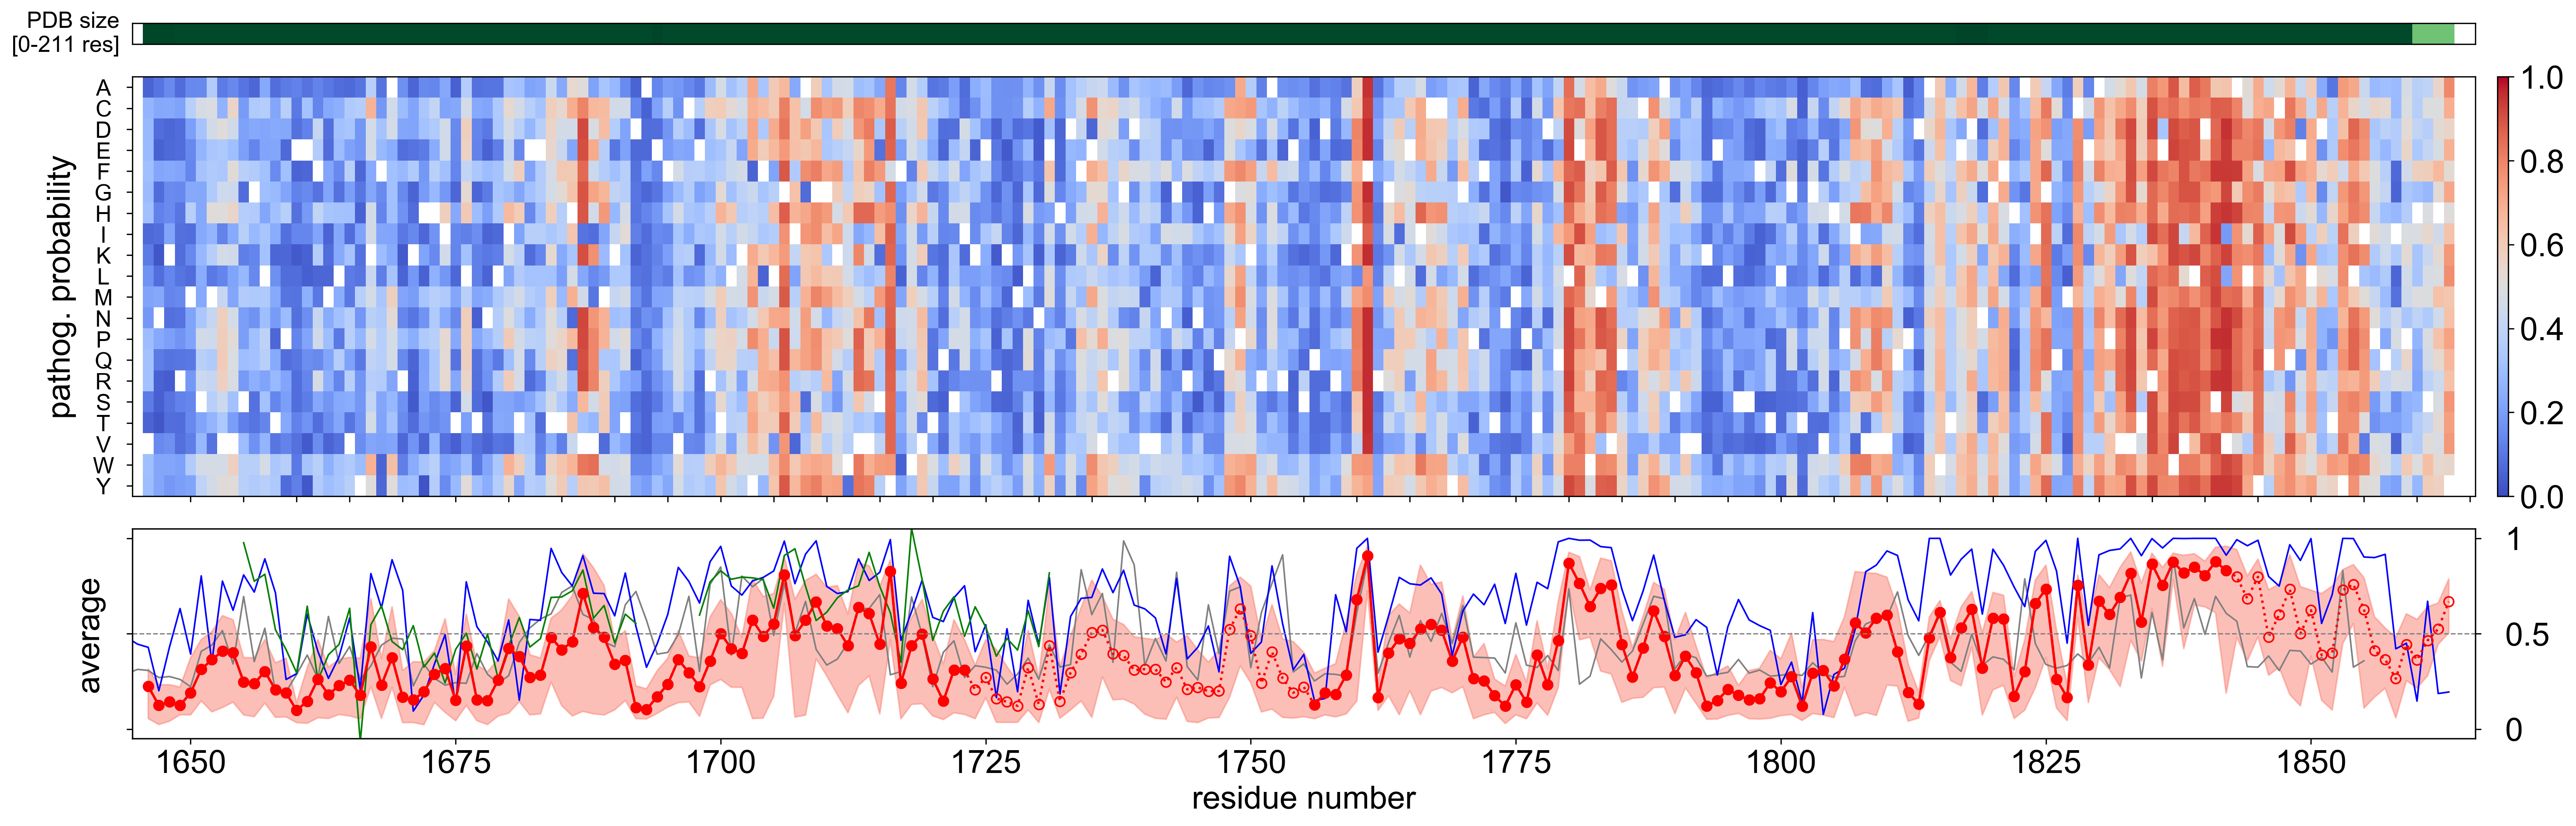

In [23]:
Image('local/figures/sat_mutagen-BRCT.png')